Conteos obtenidos del simulador:
{'110011010101': 62469, '101101010110': 62593, '000000111011': 62472, '100011101101': 62332, '010110100010': 62779, '000000000111': 62425, '000000011110': 62542, '101011001001': 62751, '010001111100': 62683, '011010010100': 62234, '111111110011': 62561, '001100100000': 62630, '111100101111': 62308, '001010111010': 62761, '100101100001': 62180, '101110001000': 62280}
Valores de la imagen original:
[[ 76 105  90 255]
 [150 179 173   0]
 [ 29  53 212 192]
 [226 113 128  79]]
Valores de la imagen reconstruida:
[[ 30.   0. 186.  32.]
 [124. 162. 148.   0.]
 [237.  97. 201. 136.]
 [213.   0.   0.  47.]]
Error cuadrático medio (MSE): 9529.9375


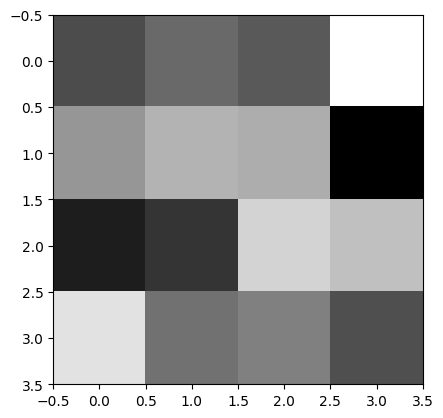

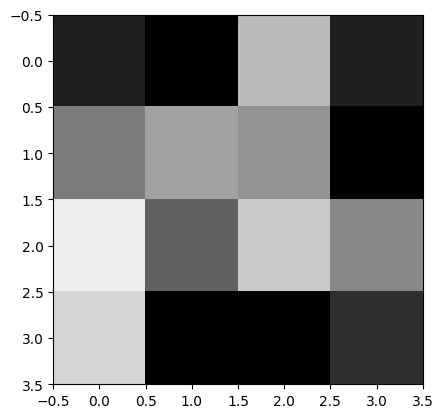

In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class NEQREncoder:
    def __init__(self, image_path):
        self.image_path = image_path
        self.position_qubits = 4  # Qubits para representar posiciones de los píxeles
        self.intensity_qubits = 8  # Qubits para codificar intensidades en escala de grises (0-255)
        self.qc = QuantumCircuit(self.position_qubits + self.intensity_qubits, self.position_qubits + self.intensity_qubits)
        self.backend_sim = AerSimulator()

    def image_preprocessing(self):
        image = Image.open(self.image_path).convert('L')
        image = image.resize((4, 4))  # Redimensionar a 4x4
        image_array = np.array(image)  # Escala de grises sin normalizar
        return image_array.flatten()

    def apply_hadamard(self):
        self.qc.h(range(self.position_qubits))  # Hadamard en qubits de posición

    def apply_neqr_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            bin_pixel = format(pixel, '08b')  # Convertir intensidad a binario de 8 bits
            for j, bit in enumerate(bin_pixel):
                if bit == '1':
                    self.cnot_position_intensity(i, j)

    def cnot_position_intensity(self, pixel_position, intensity_bit):
        bin_position = format(pixel_position, '04b')
        controls = [int(b) for b in bin_position]
        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)
        
        self.qc.mcx(list(range(self.position_qubits)), self.position_qubits + intensity_bit)

        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)

    def run_simulation(self):
        self.qc.measure(range(self.position_qubits + self.intensity_qubits), range(self.position_qubits + self.intensity_qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=1000000).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts):
        reconstructed = np.zeros(16)  # 16 píxeles para una imagen 4x4
        for bitstring, count in counts.items():
            position = bitstring[:4]  # Los primeros 4 bits representan la posición del píxel
            intensity_bin = bitstring[4:]  # Los siguientes 8 bits representan la intensidad
            pixel_position = int(position, 2)  # Convertimos la posición a un número decimal
            pixel_intensity = int(intensity_bin, 2)  # Convertimos la intensidad de binario a decimal
            reconstructed[pixel_position] = pixel_intensity  # Asignamos el valor de intensidad al píxel correspondiente

        return reconstructed

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original_neqr.txt', original.reshape(4, 4), fmt='%d')
        np.savetxt('imagen_generada_neqr.txt', reconstructed.reshape(4, 4), fmt='%d')

    def show_images(self, original, reconstructed):
        plt.imshow(original.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Imagen_NEQR.png')
        plt.show()
        plt.imshow(reconstructed.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Reconstruccion_NEQR.png')
        plt.show()

    def draw_circuit_text(self, filename='circuito_neqr_joel.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self):
        pixel_data = self.image_preprocessing()
        self.apply_hadamard()
        self.apply_neqr_encoding(pixel_data)

        counts = self.run_simulation()

        # Imprimir los resultados de los conteos después de la simulación
        print("Conteos obtenidos del simulador:")
        print(counts)
        
        genimg = self.reconstruct_image(counts)
        original_img = pixel_data

        # Imprimir los valores de las imágenes originales y reconstruidas
        print("Valores de la imagen original:")
        print(original_img.reshape(4, 4))  # Formatear como una matriz 4x4
        print("Valores de la imagen reconstruida:")
        print(genimg.reshape(4, 4))  # Formatear como una matriz 4x4

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    neqr_encoder = NEQREncoder('img/imagen_4x4.png')
    neqr_encoder.run()


Conteos obtenidos del simulador:
{'101110001000': 6254, '100011101101': 6358, '001100100000': 6227, '101101010110': 6277, '010110100010': 6314, '000000000111': 6264, '000000011110': 6177, '100101100001': 6120, '111100101111': 6191, '001010111010': 6363, '111111110011': 6247, '000000111011': 6241, '110011010101': 6241, '101011001001': 6258, '011010010100': 6234, '010001111100': 6234}
Valores de la imagen original:
[[ 76 105  90 255]
 [150 179 173   0]
 [ 29  53 212 192]
 [226 113 128  79]]
Valores de la imagen reconstruida:
[[ 31.97607323   0.         186.          32.        ]
 [124.         162.         148.           0.        ]
 [237.          97.         201.         110.9541138 ]
 [213.           0.           0.         145.44122849]]
Error cuadrático medio (MSE): 9945.24866516539


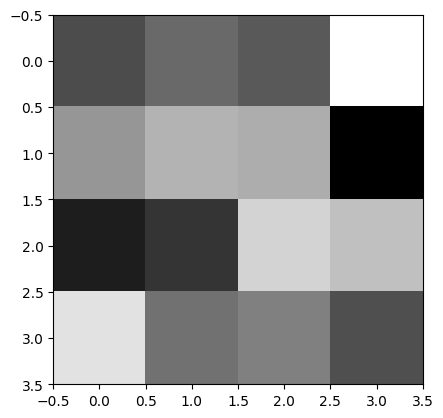

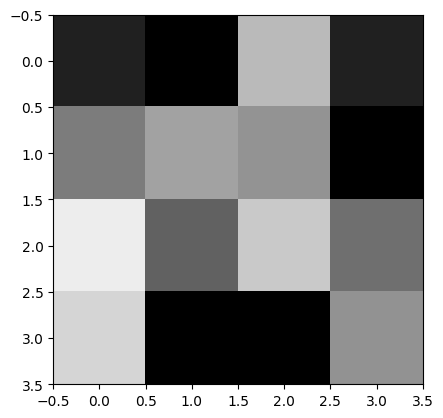

In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class NEQREncoder:
    def __init__(self, image_path, shots=100000):
        self.image_path = image_path
        self.shots = shots  # Parámetro para definir el número de tiros
        self.position_qubits = 4  # Qubits para representar posiciones de los píxeles
        self.intensity_qubits = 8  # Qubits para codificar intensidades en escala de grises (0-255)
        self.qc = QuantumCircuit(self.position_qubits + self.intensity_qubits, self.position_qubits + self.intensity_qubits)
        self.backend_sim = AerSimulator()

    def image_preprocessing(self):
        image = Image.open(self.image_path).convert('L')
        image = image.resize((4, 4))  # Redimensionar a 4x4
        image_array = np.array(image)  # Escala de grises sin normalizar
        return image_array.flatten()

    def apply_hadamard(self):
        self.qc.h(range(self.position_qubits))  # Hadamard en qubits de posición

    def apply_neqr_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            bin_pixel = format(pixel, '08b')  # Convertir intensidad a binario de 8 bits
            for j, bit in enumerate(bin_pixel):
                if bit == '1':
                    self.cnot_position_intensity(i, j)

    def cnot_position_intensity(self, pixel_position, intensity_bit):
        bin_position = format(pixel_position, '04b')
        controls = [int(b) for b in bin_position]
        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)
        
        self.qc.mcx(list(range(self.position_qubits)), self.position_qubits + intensity_bit)

        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)

    def run_simulation(self):
        self.qc.measure(range(self.position_qubits + self.intensity_qubits), range(self.position_qubits + self.intensity_qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=self.shots).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts):
        reconstructed = np.zeros(16)  # 16 píxeles para una imagen 4x4
        intensity_sums = np.zeros(16)  # Para acumular las intensidades ponderadas
        count_sums = np.zeros(16)  # Para acumular los conteos totales por píxel
        
        for bitstring, count in counts.items():
            position = bitstring[:4]  # Los primeros 4 bits representan la posición del píxel
            intensity_bin = bitstring[4:]  # Los siguientes 8 bits representan la intensidad
            pixel_position = int(position, 2)  # Convertimos la posición a un número decimal
            pixel_intensity = int(intensity_bin, 2)  # Convertimos la intensidad de binario a decimal

            # Acumular la intensidad ponderada por el conteo
            intensity_sums[pixel_position] += pixel_intensity * count
            count_sums[pixel_position] += count

        # Calcular la intensidad promedio ponderada para cada píxel
        for i in range(16):
            if count_sums[i] > 0:
                reconstructed[i] = intensity_sums[i] / count_sums[i]  # Promedio ponderado

        return reconstructed

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original_neqr.txt', original.reshape(4, 4), fmt='%d')
        np.savetxt('imagen_generada_neqr.txt', reconstructed.reshape(4, 4), fmt='%d')

    def show_images(self, original, reconstructed):
        plt.imshow(original.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Imagen_NEQR.png')
        plt.show()
        plt.imshow(reconstructed.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Reconstruccion_NEQR.png')
        plt.show()

    def draw_circuit_text(self, filename='circuito_neqr_joel.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self):
        pixel_data = self.image_preprocessing()
        self.apply_hadamard()
        self.apply_neqr_encoding(pixel_data)

        counts = self.run_simulation()

        # Imprimir los resultados de los conteos después de la simulación
        print("Conteos obtenidos del simulador:")
        print(counts)
        
        genimg = self.reconstruct_image(counts)
        original_img = pixel_data

        # Imprimir los valores de las imágenes originales y reconstruidas
        print("Valores de la imagen original:")
        print(original_img.reshape(4, 4))  # Formatear como una matriz 4x4
        print("Valores de la imagen reconstruida:")
        print(genimg.reshape(4, 4))  # Formatear como una matriz 4x4

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    neqr_encoder = NEQREncoder('img/imagen_4x4.png', shots=100000)  # Aumentar el número de tiros a 100,000
    neqr_encoder.run()


Conteos obtenidos del simulador:
{'111111110011': 6288, '101011001001': 6201, '110011010101': 6180, '010001111100': 6135, '011010010100': 6222, '101110001000': 6201, '010110100010': 6252, '000000000111': 6197, '000000011110': 6388, '101101010110': 6282, '100011101101': 6206, '000000111011': 6211, '001100100000': 6495, '100101100001': 6325, '111100101111': 6214, '001010111010': 6203}
Valores de la imagen original:
[[ 76 105  90 255]
 [150 179 173   0]
 [ 29  53 212 192]
 [226 113 128  79]]
Valores de la imagen reconstruida:
[[ 31.99978719   0.         186.          32.        ]
 [124.         162.         148.           0.        ]
 [237.          97.         201.         110.83777938]
 [213.           0.           0.         145.58006719]]
Error cuadrático medio (MSE): 9947.451883145979


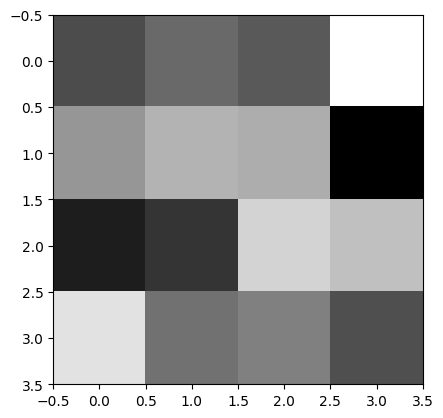

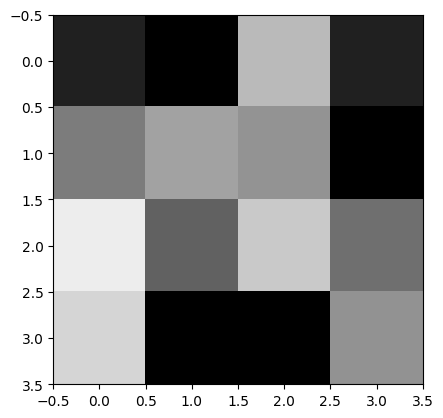

In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class NEQREncoder:
    def __init__(self, image_path, shots=100000):
        self.image_path = image_path
        self.shots = shots  # Parámetro para definir el número de tiros
        self.position_qubits = 4  # Qubits para representar posiciones de los píxeles
        self.intensity_qubits = 8  # Qubits para codificar intensidades en escala de grises (0-255)
        self.qc = QuantumCircuit(self.position_qubits + self.intensity_qubits, self.position_qubits + self.intensity_qubits)
        self.backend_sim = AerSimulator()

    def image_preprocessing(self):
        image = Image.open(self.image_path).convert('L')
        image = image.resize((4, 4))  # Redimensionar a 4x4
        image_array = np.array(image)  # Escala de grises sin normalizar
        return image_array.flatten()

    def apply_hadamard(self):
        self.qc.h(range(self.position_qubits))  # Hadamard en qubits de posición

    def apply_neqr_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            bin_pixel = format(pixel, '08b')  # Convertir intensidad a binario de 8 bits
            for j, bit in enumerate(bin_pixel):
                if bit == '1':
                    self.cnot_position_intensity(i, j)

    def cnot_position_intensity(self, pixel_position, intensity_bit):
        bin_position = format(pixel_position, '04b')
        controls = [int(b) for b in bin_position]
        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)
        
        self.qc.mcx(list(range(self.position_qubits)), self.position_qubits + intensity_bit)

        for i, control in enumerate(controls):
            if control == 0:
                self.qc.x(self.position_qubits - i - 1)

    def run_simulation(self):
        self.qc.measure(range(self.position_qubits + self.intensity_qubits), range(self.position_qubits + self.intensity_qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=self.shots).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts):
        reconstructed = np.zeros(16)  # 16 píxeles para una imagen 4x4
        intensity_sums = np.zeros(16)  # Para acumular las intensidades ponderadas
        count_sums = np.zeros(16)  # Para acumular los conteos totales por píxel
        
        for bitstring, count in counts.items():
            position = bitstring[:4]  # Los primeros 4 bits representan la posición del píxel
            intensity_bin = bitstring[4:]  # Los siguientes 8 bits representan la intensidad
            pixel_position = int(position, 2)  # Convertimos la posición a un número decimal
            pixel_intensity = int(intensity_bin, 2)  # Convertimos la intensidad de binario a decimal

            # Acumular la intensidad ponderada por el conteo
            intensity_sums[pixel_position] += pixel_intensity * count
            count_sums[pixel_position] += count

        # Calcular la intensidad promedio ponderada para cada píxel
        for i in range(16):
            if count_sums[i] > 0:
                reconstructed[i] = intensity_sums[i] / count_sums[i]  # Promedio ponderado

        return reconstructed

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original_neqr.txt', original.reshape(4, 4), fmt='%d')
        np.savetxt('imagen_generada_neqr.txt', reconstructed.reshape(4, 4), fmt='%d')

    def show_images(self, original, reconstructed):
        plt.imshow(original.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Imagen_NEQR.png')
        plt.show()
        plt.imshow(reconstructed.reshape(4, 4), cmap='gray', vmin=0, vmax=255)
        plt.savefig('Reconstruccion_NEQR.png')
        plt.show()

    def draw_circuit_text(self, filename='circuito_neqr_joel.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self):
        pixel_data = self.image_preprocessing()
        self.apply_hadamard()
        self.apply_neqr_encoding(pixel_data)

        counts = self.run_simulation()

        # Imprimir los resultados de los conteos después de la simulación
        print("Conteos obtenidos del simulador:")
        print(counts)
        
        genimg = self.reconstruct_image(counts)
        original_img = pixel_data

        # Imprimir los valores de las imágenes originales y reconstruidas
        print("Valores de la imagen original:")
        print(original_img.reshape(4, 4))  # Formatear como una matriz 4x4
        print("Valores de la imagen reconstruida:")
        print(genimg.reshape(4, 4))  # Formatear como una matriz 4x4

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    neqr_encoder = NEQREncoder('img/imagen_4x4.png', shots=100000)  # Aumentar el número de tiros a 100,000
    neqr_encoder.run()


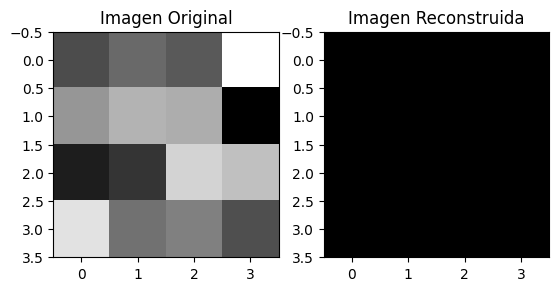

Mean Squared Error: 21645.25


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Función para convertir imagen a escala de grises
def convert_to_grayscale(image_path, new_size):
    image = Image.open(image_path).convert("L")  # "L" es para escala de grises
    image = image.resize(new_size)
    image_array = np.array(image)
    return image_array

# Función para codificar la imagen utilizando NEQR
def neqr_encoding(image):
    n_qubits = int(np.ceil(np.log2(image.size))) + 8  # Añadimos 8 qubits para representar los píxeles (8 bits)
    circuit = QuantumCircuit(n_qubits, 8)  # Añadimos 8 qubits clásicos para la medición

    # Normalización de píxeles para codificarlos en qubits
    max_pixel_value = 255
    for index, pixel_value in np.ndenumerate(image):
        # Convertimos el índice y el valor del pixel a binario
        pixel_bin = format(pixel_value, '08b')
        index_bin = format(np.ravel_multi_index(index, image.shape), f'0{n_qubits - 8}b')

        # Aplicamos X (NOT) a los qubits para las posiciones correspondientes
        for i, bit in enumerate(index_bin):
            if bit == '1':
                circuit.x(i)

        # Codificamos el valor del píxel usando puertas controladas
        for j, bit in enumerate(pixel_bin):
            if bit == '1':
                circuit.ccx(0, 1, n_qubits - 1 - j)  # Controlada por los primeros qubits para simplificar el ejemplo

        # Reseteamos los qubits de índice
        for i, bit in enumerate(index_bin):
            if bit == '1':
                circuit.x(i)

    # Añadimos la medición de los últimos 8 qubits para obtener los píxeles
    circuit.measure(range(n_qubits - 8, n_qubits), range(8))
    
    return circuit

# Función para decodificar la imagen desde un estado cuántico (simulado)
def neqr_decoding(counts, image_shape, n_qubits):
    n_pixels = image_shape[0] * image_shape[1]
    decoded_image = np.zeros(n_pixels)

    # Extraemos las mediciones del simulador
    for state, count in counts.items():
        if len(state) >= 8:  # Nos aseguramos de que la cadena tenga al menos 8 bits
            pixel_value = int(state[-8:], 2)  # Últimos 8 bits para el valor del píxel
            if len(state[:-8]) > 0:  # Verificamos si hay bits para el índice
                pixel_index = int(state[:-8], 2)  # Los otros bits para el índice del píxel
                decoded_image[pixel_index] = pixel_value
    
    return decoded_image.reshape(image_shape)

# Simulador y ejecución
def simulate_neqr(image, circuit):
    simulator = AerSimulator()
    transpiled_circuit = transpile(circuit, simulator)
    result = simulator.run(transpiled_circuit, shots=1024).result()  # Usamos .run en lugar de execute
    counts = result.get_counts()
    n_qubits = circuit.num_qubits
    return neqr_decoding(counts, image.shape, n_qubits)

# Carga y procesamiento de la imagen
image_path = 'img/imagen_4x4.png'  # Cambia esta ruta a tu imagen
image = convert_to_grayscale(image_path, (4, 4))  # Usamos una imagen 4x4 para este ejemplo

# Codificación NEQR
circuit = neqr_encoding(image)

# Simulación y decodificación
decoded_image = simulate_neqr(image, circuit)

# Visualización de la imagen original y la reconstruida
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(decoded_image, cmap='gray')
plt.title('Imagen Reconstruida')

plt.show()

# Cálculo del error cuadrático medio (MSE)
mse = mean_squared_error(image, decoded_image)
print(f"Mean Squared Error: {mse}")
